# Scale-resolved correlation test with noise sweep (Appendix A + robustness)

This notebook extends the Appendix A construction by adding a depolarizing noise sweep:

\[
\rho(p) = (1-p)\rho + p\, \frac{I}{16}, \quad
\sigma(p) = (1-p)\sigma + p\, \frac{I}{16}
\]

We compute as functions of \(p\in[0,1]\):

- Total mutual information: \(I_0(p)=I(L:R)\)
- Coarse mutual information: \(I_1(p)=I(L_0:R_0)\)
- Scale profile: \(E_0(p)=I_0(p)-I_1(p),\; E_1(p)=I_1(p)\)
- Coarse-interface log-negativity (2-qubit entanglement witness)

Qubit order throughout: **[L0, L1, R0, R1]**.


In [19]:
import numpy as np
import matplotlib.pyplot as plt

def bell_state_phi_plus():
    # |Φ+> = (|00> + |11>)/sqrt(2)
    v = np.zeros((4,), dtype=complex)
    v[0] = 1/np.sqrt(2)
    v[3] = 1/np.sqrt(2)
    return v

def dm_from_state(psi):
    psi = psi.reshape((-1,1))
    return psi @ psi.conj().T

def kron(*args):
    out = np.array([[1.0+0j]])
    for a in args:
        out = np.kron(out, a)
    return out

def permute_qubits_density(rho, perm):
    """Permute qubit order for an n-qubit density matrix."""
    n = int(round(np.log2(rho.shape[0])))
    assert rho.shape == (2**n, 2**n)
    assert len(perm) == n
    rho_t = rho.reshape([2]*n + [2]*n)
    ket_axes = list(range(n))
    bra_axes = list(range(n, 2*n))
    new_ket_axes = [ket_axes[i] for i in perm]
    new_bra_axes = [bra_axes[i] for i in perm]
    rho_perm = np.transpose(rho_t, axes=new_ket_axes + new_bra_axes)
    return rho_perm.reshape((2**n, 2**n))

def partial_trace(rho, keep, dims=None):
    """
    Partial trace of a density matrix rho over subsystems not in `keep`.

    rho: (D,D) density matrix
    keep: list of subsystem indices to keep (0-based)
    dims: list of subsystem dimensions. If None, assume qubits (all 2s).
    """
    import numpy as np

    rho = np.asarray(rho)
    if rho.ndim != 2 or rho.shape[0] != rho.shape[1]:
        raise ValueError("rho must be a square matrix")

    D = rho.shape[0]

    if dims is None:
        # assume qubits
        n = int(round(np.log2(D)))
        if 2 ** n != D:
            raise ValueError(f"Cannot infer qubit dims from D={D}")
        dims = [2] * n
    else:
        dims = list(dims)
        n = len(dims)
        if int(np.prod(dims)) != D:
            raise ValueError(f"dims product {int(np.prod(dims))} does not match D={D}")

    keep = list(keep)
    if any(k < 0 or k >= n for k in keep):
        raise ValueError("keep contains out of range subsystem index")

    # subsystems to trace out
    trace_out = [i for i in range(n) if i not in keep]

    # reshape into tensor with 2n indices: (dims..., dims...)
    rho_t = rho.reshape(dims + dims)

    # trace out in descending order so axis bookkeeping stays valid
    cur_dims = dims[:]
    cur_n = n
    for i in sorted(trace_out, reverse=True):
        rho_t = np.trace(rho_t, axis1=i, axis2=i + cur_n)
        cur_dims.pop(i)
        cur_n -= 1

    d_keep = int(np.prod(cur_dims)) if cur_dims else 1
    return rho_t.reshape((d_keep, d_keep))

def von_neumann_entropy(rho, base=2):
    rhoH = (rho + rho.conj().T)/2
    evals = np.linalg.eigvalsh(rhoH)
    evals = np.clip(evals.real, 0, 1)
    nz = evals[evals > 1e-12]
    return float(-(nz*np.log(nz)).sum() / np.log(base))

def MI_on_qubits(rho, A, B, n=4):
    """Quantum mutual information I(A:B) for subsets A,B of qubit indices."""
    A = sorted(A); B = sorted(B)
    assert set(A).isdisjoint(set(B))
    AB = sorted(A+B)

    rho_AB = partial_trace(rho, keep=AB)
    pos = {q:i for i,q in enumerate(AB)}
    Apos = [pos[q] for q in A]
    Bpos = [pos[q] for q in B]

    rho_A = partial_trace(rho_AB, keep=Apos)
    rho_B = partial_trace(rho_AB, keep=Bpos)

    S_AB = von_neumann_entropy(rho_AB)
    S_A  = von_neumann_entropy(rho_A)
    S_B  = von_neumann_entropy(rho_B)
    return S_A + S_B - S_AB

def log_negativity_two_qubits(rho_2q):
    """Log negativity for a 2-qubit density matrix (base-2)."""
    rho_t = rho_2q.reshape(2,2,2,2)  # a,b,a',b'
    rho_pt = np.transpose(rho_t, axes=(0,3,2,1)).reshape(4,4)  # transpose b and b'
    evals = np.linalg.eigvals(rho_pt)
    tr_norm = float(np.sum(np.abs(evals)))
    return float(np.log2(tr_norm))

def depolarize(rho, p):
    d = rho.shape[0]
    ident = np.eye(d, dtype=complex) / d
    return (1-p)*rho + p*ident


In [20]:
# Build ρ and σ (pure states) in ordering [L0, L1, R0, R1]

phi = bell_state_phi_plus()
rho_bell = dm_from_state(phi)

# ρ: Bell on (L0,R0) and (L1,R1)
# Build in [L0,R0,L1,R1] then permute -> [L0,L1,R0,R1]
rho_tmp = kron(rho_bell, rho_bell)              # [L0,R0,L1,R1]
rho_aligned = permute_qubits_density(rho_tmp, perm=[0,2,1,3])

# σ: Bell on (L0,R1) and (L1,R0)
# Build in [L0,R1,L1,R0] then permute -> [L0,L1,R0,R1]
sigma_tmp = kron(rho_bell, rho_bell)            # [L0,R1,L1,R0]
sigma_cross = permute_qubits_density(sigma_tmp, perm=[0,2,3,1])

print('Tr(ρ)=', np.trace(rho_aligned).real)
print('Tr(σ)=', np.trace(sigma_cross).real)

L = [0,1]
R = [2,3]
print('I(L:R) ρ =', MI_on_qubits(rho_aligned, L, R))
print('I(L:R) σ =', MI_on_qubits(sigma_cross, L, R))
print('I(L0:R0) ρ =', MI_on_qubits(rho_aligned, [0], [2]))
print('I(L0:R0) σ =', MI_on_qubits(sigma_cross, [0], [2]))


Tr(ρ)= 0.9999999999999996
Tr(σ)= 0.9999999999999996
I(L:R) ρ = 3.999999999999999
I(L:R) σ = 3.999999999999999
I(L0:R0) ρ = 1.9999999999999998
I(L0:R0) σ = 6.661338147750939e-16


In [21]:
# Noise sweep

ps = np.linspace(0, 1, 101)

I0_r, I0_s = [], []
I1_r, I1_s = [], []
E0_r, E0_s = [], []
E1_r, E1_s = [], []
LN_r, LN_s = [], []

for p in ps:
    r = depolarize(rho_aligned, p)
    s = depolarize(sigma_cross, p)

    I0rp = MI_on_qubits(r, L, R)
    I0sp = MI_on_qubits(s, L, R)
    I1rp = MI_on_qubits(r, [0], [2])
    I1sp = MI_on_qubits(s, [0], [2])

    I0_r.append(I0rp); I0_s.append(I0sp)
    I1_r.append(I1rp); I1_s.append(I1sp)

    E0_r.append(I0rp - I1rp); E0_s.append(I0sp - I1sp)
    E1_r.append(I1rp);        E1_s.append(I1sp)

    # Coarse interface log-negativity
    r_L0R0 = partial_trace(r, keep=[0,2])
    s_L0R0 = partial_trace(s, keep=[0,2])
    LN_r.append(log_negativity_two_qubits(r_L0R0))
    LN_s.append(log_negativity_two_qubits(s_L0R0))

print('Done. Example values:')
idxs = [0, 25, 50, 75, 100]
for i in idxs:
    print(f'p={ps[i]:.2f}  I0ρ={I0_r[i]:.3f} I0σ={I0_s[i]:.3f}  I1ρ={I1_r[i]:.3f} I1σ={I1_s[i]:.3f}  LNρ={LN_r[i]:.3f} LNσ={LN_s[i]:.3f}')


Done. Example values:
p=0.00  I0ρ=4.000 I0σ=4.000  I1ρ=2.000 I1σ=0.000  LNρ=1.000 LNσ=-0.000
p=0.25  I0ρ=2.299 I0σ=2.299  I1ρ=1.007 I1σ=0.000  LNρ=0.700 LNσ=-0.000
p=0.50  I0ρ=1.171 I0σ=1.171  I1ρ=0.451 I1σ=0.000  LNρ=0.322 LNσ=-0.000
p=0.75  I0ρ=0.376 I0σ=0.376  I1ρ=0.120 I1σ=0.000  LNρ=-0.000 LNσ=-0.000
p=1.00  I0ρ=0.000 I0σ=0.000  I1ρ=0.000 I1σ=0.000  LNρ=0.000 LNσ=0.000


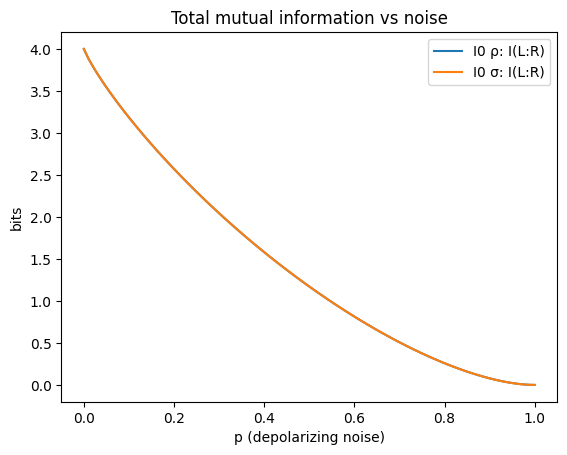

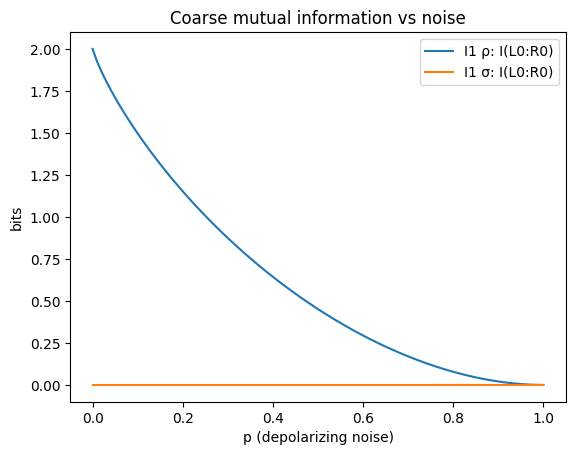

In [22]:
# Plot: mutual informations

plt.figure()
plt.plot(ps, I0_r, label='I0 ρ: I(L:R)')
plt.plot(ps, I0_s, label='I0 σ: I(L:R)')
plt.xlabel('p (depolarizing noise)')
plt.ylabel('bits')
plt.title('Total mutual information vs noise')
plt.legend()
plt.savefig('figure_total_mutual_information.png', dpi=300)
plt.show()

plt.figure()
plt.plot(ps, I1_r, label='I1 ρ: I(L0:R0)')
plt.plot(ps, I1_s, label='I1 σ: I(L0:R0)')
plt.xlabel('p (depolarizing noise)')
plt.ylabel('bits')
plt.title('Coarse mutual information vs noise')
plt.legend()
plt.savefig('figure_coarse_mutual_information.png', dpi=300)
plt.show()


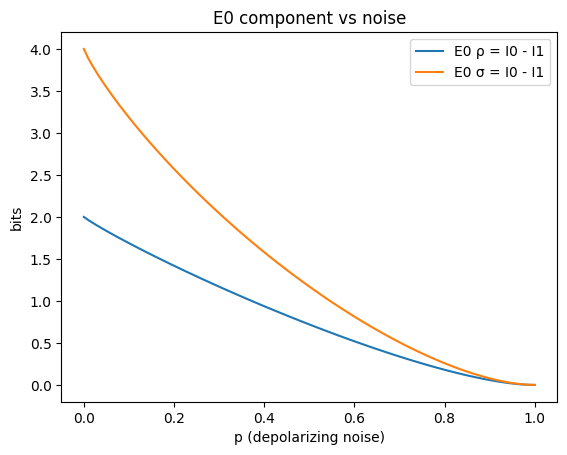

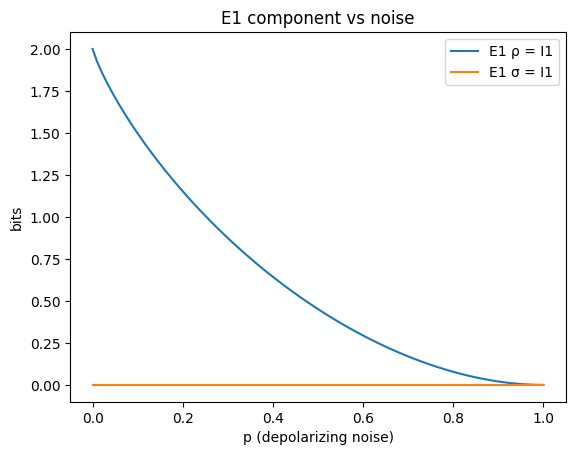

In [23]:
# Plot: scale profile components

plt.figure()
plt.plot(ps, E0_r, label='E0 ρ = I0 - I1')
plt.plot(ps, E0_s, label='E0 σ = I0 - I1')
plt.xlabel('p (depolarizing noise)')
plt.ylabel('bits')
plt.title('E0 component vs noise')
plt.legend()
plt.savefig('figure_E0_component.png', dpi=300)
plt.show()

plt.figure()
plt.plot(ps, E1_r, label='E1 ρ = I1')
plt.plot(ps, E1_s, label='E1 σ = I1')
plt.xlabel('p (depolarizing noise)')
plt.ylabel('bits')
plt.title('E1 component vs noise')
plt.legend()
plt.savefig('figure_E1_component.png', dpi=300)
plt.show()


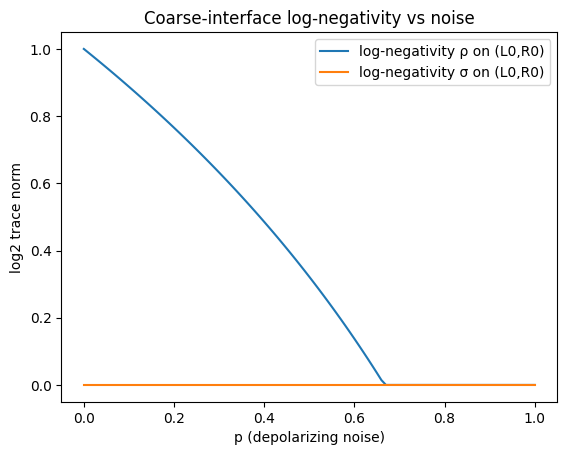

In [24]:
# Plot: coarse-interface entanglement witness (log-negativity)

plt.figure()
plt.plot(ps, LN_r, label='log-negativity ρ on (L0,R0)')
plt.plot(ps, LN_s, label='log-negativity σ on (L0,R0)')
plt.xlabel('p (depolarizing noise)')
plt.ylabel('log2 trace norm')
plt.title('Coarse-interface log-negativity vs noise')
plt.legend()
plt.savefig('figure_log_negativity.png', dpi=300)
plt.show()


## What you should see

- **Total MI** curves for ρ and σ lie on top of each other (up to numerical noise).
- **Coarse MI** differs strongly: ρ retains correlation at the coarse interface, σ does not (until noise dominates).
- **Scale profile** separates:
  - ρ starts near \((E_0,E_1)=(2,2)\)
  - σ starts near \((E_0,E_1)=(4,0)\)
- **Log-negativity** at coarse interface is positive for ρ at low noise and near zero for σ (and both decay with noise).

This is the robustness visualization you can attach to the pre-write for external review.
